In [44]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [45]:
from d07_visualization.viz_training import plot_acc, plot_training_loss, plot_losses
from d04_mixmatch.wideresnet import WideResNet
from d02_data.load_data import get_dataloaders_ssl
from d02_data.load_data_idxs import get_dataloaders_with_index
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [77]:
model_name = 'sgd_250/checkpoint_30000_unlearns.pt'
saved_model = torch.load(f'../models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10, bias=False)
model.load_state_dict(saved_model['model_state_dict'])

# optim = ...
# optim.load_state_dict(saved_model['optimizer_state_dict'])

loss_train = saved_model['loss_train']
loss_val = saved_model['loss_val']
acc_train = saved_model['acc_train']
acc_val = saved_model['acc_val']

loss_batch = saved_model['loss_batch']
lx = saved_model['lx']
lu = saved_model['lu']
lu_weighted = saved_model['lu_weighted']

saved_model.keys()

dict_keys(['step', 'model_state_dict', 'ema_state_dict', 'optimizer_state_dict', 'loss_train', 'loss_val', 'acc_train', 'acc_val', 'loss_batch', 'lx', 'lu', 'lu_weighted', 'steps', 'batch_size', 'num_labels', 'lambda_u_max', 'step_top_up', 'lr', 'weight_decay', 'momentum', 'lr_decay', 'lbl_idx', 'unlbl_idx', 'val_idx'])

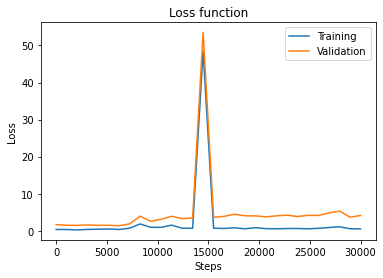

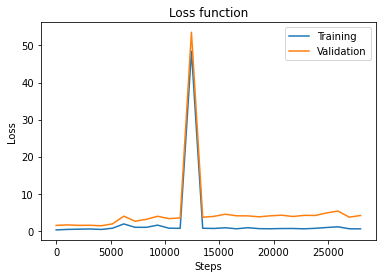

In [78]:
plot_training_loss(loss_train, loss_val, step=1000)
plt.show()
plot_training_loss(loss_train[2:], loss_val[2:], step=1000)


Max val acc: 61.7


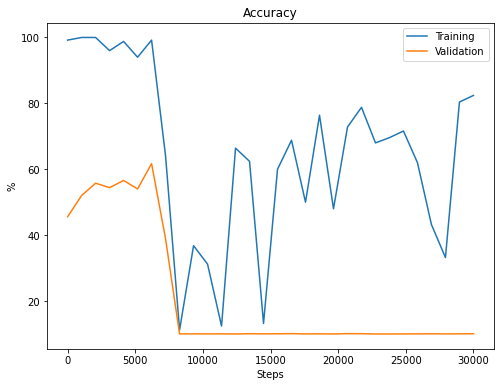

In [88]:
plt.figure(figsize=(8,6))
print('Max val acc: ' + str(max(acc_val)))
plot_acc(acc_train, acc_val, step=1000)

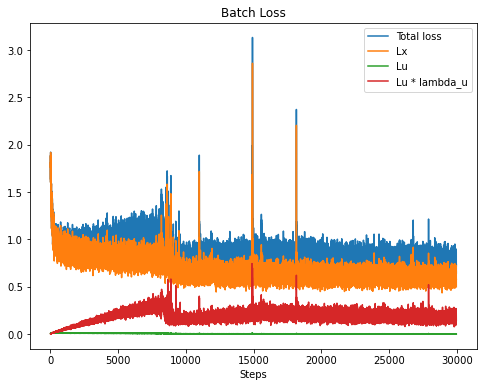

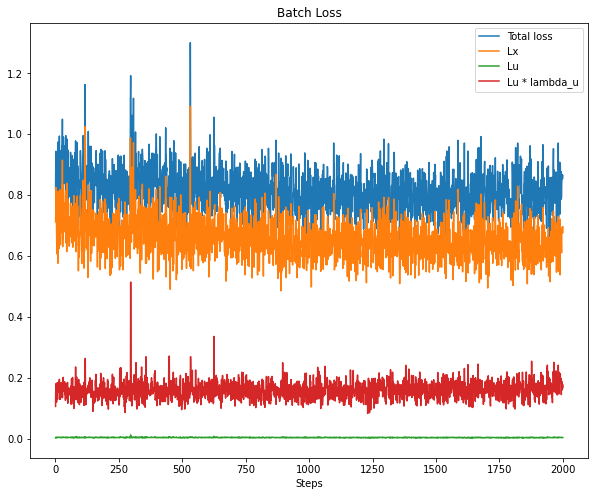

In [84]:
plt.figure(figsize=(8,6))
plot_losses(loss_batch[50:], lx[50:], lu[50:], lu_weighted[50:])
plt.show()
idx1 = 9000
idx2 = 11000
plt.figure(figsize=(10,8))
plot_losses(loss_batch[idx1:idx2], lx[idx1:idx2], lu[idx1:idx2], lu_weighted[idx1:idx2])

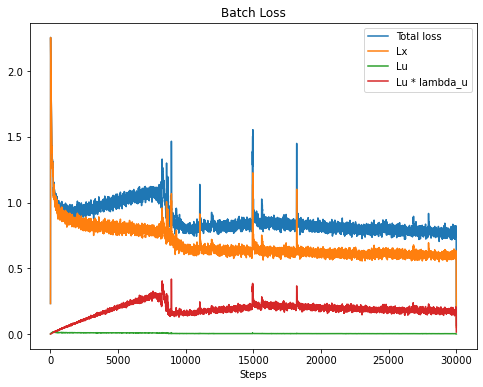

In [87]:
plt.figure(figsize=(8,6))

kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
loss_batch_f = np.convolve(loss_batch, kernel)
lx_f = np.convolve(lx, kernel)
lu_f = np.convolve(lu, kernel)
lu_weighted_f = np.convolve(lu_weighted, kernel)

plot_losses(loss_batch_f, lx_f, lu_f, lu_weighted_f)
plt.show()

In [18]:
id = np.argmax(lx[9500:10000])
print(id)
print(np.round(lx[9780:9790],2))


216
[0.99 0.94 1.06 0.97 1.08 0.98 0.91 1.13 1.02 0.96]


In [55]:
def evaluate(dataloader, adam=True):
    criterion = nn.CrossEntropyLoss()
    ema_model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            if adam:
                outputs = ema_model(inputs)
            else:
                outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    return loss, acc

_, _, val_loader, test_loader, _, _, _ = get_dataloaders_ssl(path='../data', batch_size=64, num_labeled=250)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
ema_model = WideResNet(depth=28, k=2, n_out=10, bias=False)
ema_model.load_state_dict(saved_model['ema_state_dict'])

test_loss, test_acc = evaluate(test_loader, adam=True)
print("Test accuracy: %.2f" % (test_acc))

Test accuracy: 86.52


In [11]:
val_loss, val_acc = evaluate(val_loader)
print("Val accuracy: %.2f" % (val_acc))

Val accuracy: 99.46


In [52]:
a = np.array([])
print(a.shape)


(0,)


In [11]:
loss_list = []
for i in range(10):
    loss_list.append(round(np.mean(lu[i*1000:(i+1)*1000]),3))
print(loss_list)

[0.01, 0.013, 0.011, 0.008, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004]


## Pseudo Labelling

In [21]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [82]:
from d02_data.load_data_idxs import get_dataloaders_with_index
lbl_loader, unlbl_loader, _, _, _, unlbl_indxs, _ = get_dataloaders_with_index(path='../data', batch_size=64, num_labeled=250)

Files already downloaded and verified
Files already downloaded and verified


AttributeError: 'DataLoader' object has no attribute 'targets'

In [68]:
id<

TypeError: 'numpy.int64' object is not callable

In [24]:
unlbl_batch = iter(unlbl_loader).next()
len(unlbl_batch)
print(unlbl_batch[2])

tensor([45825, 17749,  1962, 45655, 49893, 43613, 23556, 26967, 21351, 36045,
        39261, 48646, 42063, 43720, 48844, 36983,  2731,  9863, 49111, 10289,
        21111, 31230, 35459, 35350, 15366, 44494, 37226, 24230, 15515, 37233,
         6975, 25863, 26672, 43323, 28523, 15056, 20839, 21439, 23715, 27435,
         3980, 44617,  3618, 47038, 10310, 44925,  4672, 44896, 40626, 33406,
        45605, 40379, 43491, 48062, 30557, 21514, 30796, 28192, 22544, 25538,
        28817, 41407, 29517, 26023])


In [91]:
unlbl_loader.dataset.targets[36695]

9

In [94]:
import numpy as np
a = np.array([-2, 1, 5, 3, 8, 5, 6])
b = np.array([1, 2, 5])
print(list(a[b]))
# Result:
[1, 5, 5]

[1, 5, 5]


[1, 5, 5]

In [92]:
lbl_loader.dataset.targets[[0,3]]

TypeError: list indices must be integers or slices, not list

In [26]:
unlbl_batch = iter(unlbl_loader).next()[0]

p_out_max = torch.tensor([])
lbls = torch.tensor([])
for _ in range(1):
    unlbl_batch = iter(unlbl_loader).next()[0]

    p_out = torch.softmax(model(unlbl_batch), dim=1)
    p_out = p_out.detach()
    p_out_max2, lbls2 = torch.max(p_out, dim=1)
    p_out_max = torch.cat((p_out_max, p_out_max2))
    lbls = torch.cat((lbls, lbls2))

In [34]:

bb = torch.vstack((p_out_max, lbls, lbls)).T
b = torch.cat((b, bb), dim=0)
b.shape

torch.Size([192, 3])

In [42]:
b2 = torch.vstack((b.T, torch.zeros(192))).T
b2.shape

torch.Size([192, 4])

In [42]:
a = b[:,b[0] > 0.7]
a
l = a[0].tolist().extend(a[1].tolist())
l

Percentage superior to threshlold:  0.234375


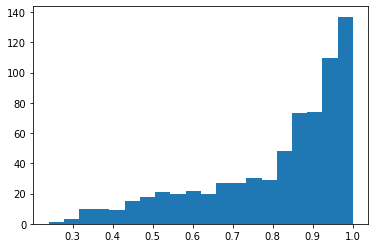

In [194]:
plt.hist(p_out_max, bins=20);
print('Percentage superior to threshlold: ', str(np.sum(p_out_max>0.95) / p_out_max.shape[0]))